In [463]:
import pandas as pd

from pytrends.request import TrendReq
pytrend = TrendReq()

from sklearn.decomposition import PCA
import statistics as stat
import numpy as np
import math

import matplotlib.pyplot as plt

In [464]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from obspy.signal.detrend import polynomial
from statsmodels.tsa.seasonal import STL
from tsmoothie.smoother import ExponentialSmoother, KalmanSmoother

In [465]:

def median_tinator(df):
    
    #Demeaning
    for values in df.columns.values:
        u = stat.mean(df[values])
        std = stat.stdev(df[values])

        df[values] = (((df[values] - u)/std) +10)

    #This on is with base year
    df = df.apply(lambda x: np.floor(((x)/x.iloc[0] * 100)))

    #calculating the median
    arr = []
    for x in df.T.columns.values:    
        arr.append(stat.median(df.T[x]))

    #Putting the array in dataframe
    df_index = pd.DataFrame({'index':arr})
    df_index = df_index.set_index(pd.Index(df.T.columns.values[:]))

    return df_index


In [466]:
def Deseasonalize_STL (df):
    # This function deseasonalizes the variables
    # Input is a the data frame of Google trends and a set of seasonal dummies
    deseasonalized = pd.DataFrame(index = df.index)


    for columns in df:
        # Create model object
        stl = STL(df[columns], period = 12)
        
        # Estimate the model
        fit = stl.fit()
        # Add the seasonal and trend components  
        deas_temp = fit._trend + fit._resid
        deseasonalized = deseasonalized.merge(deas_temp.to_frame(), left_index=True, right_index=True)
        
    deseasonalized.columns = df.columns.values    
    return deseasonalized

def ExpSmoother(df, window = 4, alpha = 0.3):
    result = pd.DataFrame(np.nan, index = df.index, columns = df.columns)
    
    
    smoother = ExponentialSmoother(window_len = window, alpha = alpha)
    
    for i in range(0,len(df.columns)):
        
        
        smooth = smoother.smooth(df.iloc[:,i])
        
        result.iloc[:window,i] = df.iloc[:window,i]
        
        result.iloc[window:,i] = smooth.smooth_data
    
    return result


def KalSmoother(df, level = .9):
    
    result = pd.DataFrame(np.nan, index = df.index, columns = df.columns)
    
    #smoother = KalmanSmoother(component='level_trend', 
                          #component_noise={'level':level, 'trend':trend})
                          
    smoother = KalmanSmoother(component='level',component_noise={'level':level})                      
    
    for i in range(0,len(df.columns)):
        
        
        smooth = smoother.smooth(df.iloc[:,i])
        
        result.iloc[:,i] = np.transpose(smooth.smooth_data)
    
    return result


def Detrend2 (df,significance,lags = 0):
    # This function detrends or first differences the Google data
    # Input is a the data frame of Google trends and a significance level: '1%', '5%' or '10%'
    Outputdf = pd.DataFrame(np.nan, index = df.index, columns = df.columns )
    
    for columns in df:
        # ADF test with a constant
        test_c = adfuller(df[columns], regression ='c', autolag='AIC', maxlag = lags)
        # ADF test with a constant and linear trend
        test_ct = adfuller(df[columns], regression ='ct', autolag='AIC', maxlag = lags)

    
        # here we test if test stat is lower than critical value
        if test_c[0]<=test_c[4][significance]:
            residuals_temp = df[columns]
        elif test_ct[0]<=test_ct[4][significance]:
            residuals_temp = polynomial(df[columns], order=1)
        else:
            residuals_temp = polynomial(df[columns], order=2)

        Outputdf[columns] = residuals_temp

    # We remove NaN caused by first differencing
    Outputdf = Outputdf.fillna(method='backfill') 
    
    return Outputdf  

In [467]:
#Loading the actual house price data
filename = 'search_data.xlsx'

xls=pd.ExcelFile(filename) 
df_house_index = pd.read_excel(xls)


#Loading the actual house price data
filename = 'hp_2.xlsx'

xls=pd.ExcelFile(filename) 
df_hp = pd.read_excel(xls)
df_hp = df_hp.set_index(pd.Index(df_house_index.T.columns.values[:150])).iloc[:,:]

In [468]:
df_house_index[72:].head()

,date,CA_house for sale,CA_house for sale ontario,CA_houses for sale,CA_homes for sale,CA_toronto house for sale,CA_house for sale calgary,CA_house for rent,CA_real estate,CA_kijiji house for sale,...,CA_house for sale mississauga,CA_hamilton house for sale,CA_house for sale in calgary,CA_house for sale in brampton,CA_house for sale in surrey,CA_house for sale windsor,CA_for sale by owner,CA_house for sale by owner,CA_house for sale in toronto,CA_house for sale montreal
72,2010-01-01,14,16,16,32,32,9,35,68,17,...,21,8,12,5,5,8,76,68,22,8
73,2010-02-01,14,21,16,29,36,14,31,64,18,...,27,12,14,8,2,4,77,45,33,10
74,2010-03-01,16,21,18,32,39,15,38,73,26,...,22,16,14,16,2,12,82,42,49,15
75,2010-04-01,18,29,18,34,38,13,36,72,19,...,26,15,15,14,1,20,87,60,33,24
76,2010-05-01,16,21,17,32,53,11,36,67,18,...,26,8,6,11,4,18,80,43,53,17


In [469]:
df_house_index = median_tinator(df_house_index.iloc[72:,1:]).reset_index().iloc[:,1:]

In [470]:
test = Deseasonalize_STL (df_house_index)

In [471]:
test_2 = ExpSmoother(test)

In [472]:
test_3 = KalSmoother(test_2)

In [473]:
test_3_d = Detrend2(test_3,significance = '10%')

In [474]:
hp_d = Detrend2(df_hp,significance = '10%')

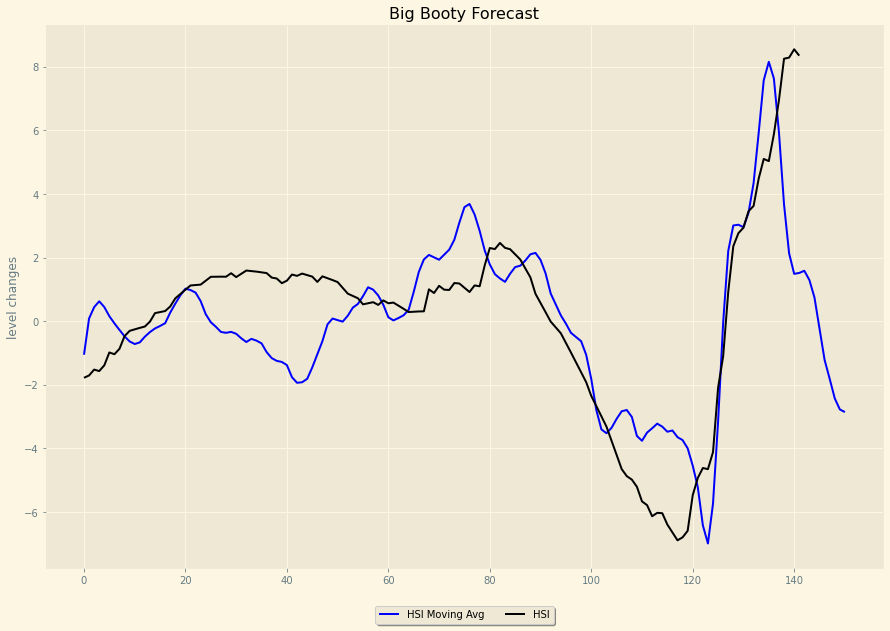

In [484]:
with plt.style.context('Solarize_Light2'):
    plt.rcParams['figure.figsize'] = [15, 10]

    # plt.plot(df_house_index[:], color='orange')
    # plt.plot(test[:], color='blue')
    # plt.plot(test_3[:], color='green')
    plt.plot(test_3_d[:], color='blue')
    plt.plot(hp_d.iloc[:,1:].shift(periods=-8), color='black')
  
    #Labling the plot
    plt.title('Big Booty Forecast')
    plt.ylabel('level changes', fontsize=12)
    plt.legend(['HSI Moving Avg','HSI','House Price'], loc='upper center', bbox_to_anchor=(0.5, -0.06),
          fancybox=True, shadow=True, ncol=4)

plt.show()

In [590]:
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import iplot

# dataframe of a wide format 
df=pd.DataFrame(test_3_d[:])

df['HP'] = hp_d.iloc[:,1:].shift(periods=-8)
df['id']=df.index


# dataframe of a long format
df = pd.melt(df, id_vars='id', value_vars=df.columns[:])

# plotly express
fig = px.line(df, x='id', y='value', color='variable',labels=dict(index="time", value="Gang gang sheet", variable="option"), width=900, height=700)
fig.update_yaxes(tickprefix="Yo ")
fig.update_layout(xaxis_showgrid=False)
fig.data[0].line.color = "red"
fig.data[1].line.color = "yellow"
fig.layout.plot_bgcolor = 'black'
fig.layout.paper_bgcolor = 'Black'

fig.show()